In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using MeshCat
using Test
using Plots

  Activating project at `~/OCRL/HW1_S25`


# Q2: Equality Constrained Optimization (25 pts)
In this problem, we are going to use Newton's method to solve some constrained optimization problems. We will start with a smaller problem where we can experiment with Full Newton vs Gauss-Newton, then we will use these methods to solve for the motor torques that make a quadruped balance on one leg.

## Part A (10 pts)
Here we are going to solve some equality-constrained optimization problems with Newton's method. We are given a problem 

$$ \begin{align} \min_x \quad & f(x) \\ 
 \text{st} \quad & c(x) = 0 
 \end{align}$$
 Which has the following Lagrangian:
 $$ \mathcal{L}(x,\lambda) = f(x) + \lambda ^T c(x), $$
and the following KKT conditions for optimality:
$$\begin{align}
\nabla_x \mathcal{L} = \nabla_x f(x) + \bigg[ \frac{\partial c}{\partial x}\bigg] ^T \lambda &= 0 \\ 
c(x) &= 0 
\end{align}$$

Which is just a root-finding problem. To solve this, we are going to solve for a $z = [x^T,\lambda]^T$ that satisfies these KKT conditions.

### Newton's Method with a Linesearch

We use Newton's method to solve for when $r(z) = 0$. To do this, we specify `res_fx(z)` as $r(z)$, and `res_jac_fx(z)` as $\partial r/ \partial z$. To calculate a Newton step, we do the following:

$$\Delta z = -\bigg[ \frac{\partial r}{\partial z} \bigg]^{-1} r(z_k)$$

We then decide the step length with a linesearch that finds the largest $\alpha \leq 1$ such that the following is true:
$$ \phi(z_k + \alpha \Delta z) < \phi(z_k)$$
Where $\phi$ is a "merit function", or `merit_fx(z)` in the code. In this assignment you will use a backtracking linesearch where $\alpha$ is initialized as $\alpha = 1.0$, and is divided by 2 until the above condition is satisfied.

NOTE: YOU DO NOT NEED TO (AND SHOULD NOT) USE A WHILE LOOP ANYWHERE IN THIS ASSIGNMENT. 

In [2]:
function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
                    max_ls_iters = 20)::Float64 # optional argument with a default
    
    # TODO: return maximum α≤1 such that merit_fx(z + α*Δz) < merit_fx(z)
    # with a backtracking linesearch (α = α/2 after each iteration)

    # NOTE: DO NOT USE A WHILE LOOP 

    b = 1e-4
    for i = 1:max_ls_iters
        alpha = 1.0 / 2^(i-1)

        #if dot(FD.gradient(merit_fx,z),Δz) < 0 #check if the direction is correct
        #    Δz = - Δz
        #end
            
        if merit_fx(z + alpha*Δz) < merit_fx(z) + b*alpha* dot(FD.gradient(merit_fx,z),Δz)
            return alpha
        end

        # TODO: return α when merit_fx(z + α*Δz) < merit_fx(z)
    end
    error("linesearch failed")
end

function newtons_method(z0::Vector, res_fx::Function, res_jac_fx::Function, merit_fx::Function;
                        tol = 1e-10, max_iters = 50, verbose = false)::Vector{Vector{Float64}}
    
    # TODO: implement Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # NOTE: DO NOT USE A WHILE LOOP ANYWHERE 
    
    # return the history of guesses as a vector
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 
    
    
    for i = 1:(max_iters - 1)
        
        # NOTE: everything here is a suggestion, do whatever you want to 
        
        # TODO: evaluate current residual 
        r = res_fx(Z[i])
        norm_r = norm(r)
        if verbose 
            print("iter: $i    |r|: $norm_r   ")
        end
        
        # TODO: check convergence with norm of residual < tol 

        # if converged, return Z[1:i]
        if norm_r < tol
            return Z[1:i]
        end
        
        # TODO: caculate Newton step (don't forget the negative sign)
        Δz = - res_jac_fx(Z[i]) \ r
        
        # TODO: linesearch and update z 
        alpha = linesearch(Z[i], Δz, merit_fx)
        Z[i+1] = Z[i] + alpha*Δz


        if verbose
            print("α: $alpha \n")
        end
        
    end
    error("Newton's method did not converge")
end

newtons_method (generic function with 1 method)

In [3]:
@testset "check Newton" begin 
    
    f(_x) = [sin(_x[1]), cos(_x[2])]
    df(_x) = FD.jacobian(f, _x)
    merit(_x) = norm(f(_x))
    
    x0 = [-1.742410372590328, 1.4020334125022704]
    
    X = newtons_method(x0, f, df, merit; tol = 1e-10, max_iters = 50, verbose = true)
    
    # check this took the correct number of iterations
    # if your linesearch isn't working, this will fail 
    # you should see 1 iteration where α = 0.5 
    @test length(X) == 6 
    
    # check we actually converged
    @test norm(f(X[end])) < 1e-10
    
end

iter: 1    |r|: 0.9995239729818045   α: 1.0 
iter: 2    |r|: 0.9421342427117169   α: 0.5 
iter: 3    |r|: 0.1753172908866053   α: 1.0 
iter: 4    |r|: 0.0018472215879181287   α: 1.0 
iter: 5    |r|: 2.1010529101114843e-9   α: 1.0 
iter: 6    |r|: 2.5246740534795566e-16   Test Summary: | Pass  Total  Time
check Newton  |    2      2  1.5s


Test.DefaultTestSet("check Newton", Any[], 2, false, false, true, 1.745281038377482e9, 1.745281039864156e9, false, "/home/burger/OCRL/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sZmlsZQ==.jl")

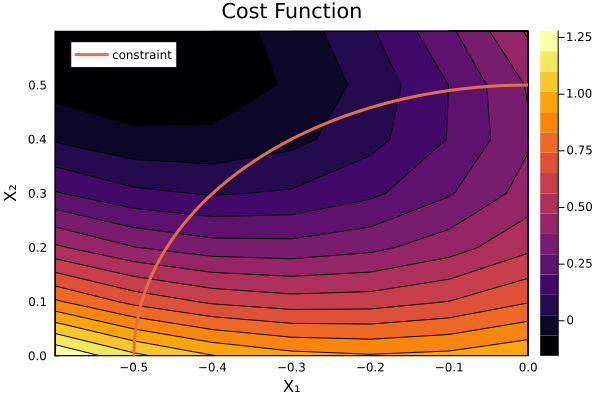

In [4]:
let
    function plotting_cost(x::Vector)
        Q = [1.65539  2.89376; 2.89376  6.51521];
        q = [2;-3]
        return 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2)
    end
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> plotting_cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
end

We will now use Newton's method to solve the following constrained optimization problem. We will write functions for the full Newton Jacobian, as well as the Gauss-Newton Jacobian. 

In [5]:
# we will use Newton's method to solve the constrained optimization problem shown above
function cost(x::Vector)
    Q = [1.65539  2.89376; 2.89376  6.51521];
    q = [2;-3]
    return 0.5*x'*Q*x + q'*x + exp(-1.3*x[1] + 0.3*x[2]^2)
end
function constraint(x::Vector)
    norm(x) - 0.5 
end
# HINT: use this if you want to, but you don't have to
function constraint_jacobian(x::Vector)::Matrix
    # since `constraint` returns a scalar value, ForwardDiff 
    # will only allow us to compute a gradient of this function 
    # (instead of a Jacobian). This means we have two options for
    # computing the Jacobian: Option 1 is to just reshape the gradient
    # into a row vector
    
    # J = reshape(FD.gradient(constraint, x), 1, 2)
    
    # or we can just make the output of constraint an array, 
    constraint_array(_x) = [constraint(_x)]
    J = FD.jacobian(constraint_array, x)
    
    # assert the jacobian has # rows = # outputs 
    # and # columns = # inputs 
    @assert size(J) == (length(constraint(x)), length(x))
    
    return J'
end
function kkt_conditions(z::Vector)::Vector
    # TODO: return the KKT conditions
    x = z[1:2]
    λ = z[3:end]
    # TODO: return the stationarity condition for the cost function
    # and the primal feasibility
    
    stationarity_cdn = FD.gradient(cost, x) + constraint_jacobian(x)*λ
    primal_feasibility = constraint(x)
    r = vcat(stationarity_cdn, primal_feasibility)
    #error("kkt not implemented")
    
    return [stationarity_cdn[1], stationarity_cdn[2], primal_feasibility]
end

function fn_kkt_jac(z::Vector)::Matrix
    # TODO: return full Newton Jacobian of kkt conditions wrt z
    x = z[1:2]
    λ = z[3]

    
    L_hess = FD.hessian(cost,x) + FD.jacobian(constraint_jacobian,x)

    kkt_jac = [L_hess constraint_jacobian(x);
               constraint_jacobian(x)' zeros(1,1)]
    kkt_jac -= 1e-3 * I(3)
    return kkt_jac

    #error("fn_kkt_jac not implemented")
    #return nothing 
end
function gn_kkt_jac(z::Vector)::Matrix
    # TODO: return Gauss-Newton Jacobian of kkt conditions wrt z 
    x = z[1:2]
    λ = z[3]

    J = FD.jacobian(x -> FD.gradient(cost,x),x)

    gnkkyt_jac = [FD.hessian(cost,x) constraint_jacobian(x);
               constraint_jacobian(x)' zeros(1,1)]
    # TODO: return Gauss-Newton jacobian with a 1e-3 regularizer
    gnkkyt_jac -= 1e-3 * I(3)
    return gnkkyt_jac
    #error("gn_kkt_jac not implemented")
    #return nothing 
end

gn_kkt_jac (generic function with 1 method)

In [6]:
@testset "Test Jacobians" begin 
    
    # first we check the regularizer 
    z = randn(3)
    J_fn = fn_kkt_jac(z)
    J_gn = gn_kkt_jac(z)
    
    # check what should/shouldn't be the same between 
    @test norm(J_fn[1:2,1:2] - J_gn[1:2,1:2]) > 1e-10
    @test abs(J_fn[3,3] + 1e-3) < 1e-10
    @test abs(J_gn[3,3] + 1e-3) < 1e-10
    @test norm(J_fn[1:2,3] - J_gn[1:2,3]) < 1e-10
    @test norm(J_fn[3,1:2] - J_gn[3,1:2]) < 1e-10
end

Test Summary:  | Pass  Total  Time
Test Jacobians |    5      5  5.5s


Test.DefaultTestSet("Test Jacobians", Any[], 5, false, false, true, 1.74528104268405e9, 1.745281048190503e9, false, "/home/burger/OCRL/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl")

iter: 1    |r|: 1.7188450769812715   α: 1.0 
iter: 2    |r|: 0.10496246835869102   α: 1.0 
iter: 3    |r|: 0.0067966851555096835   α: 1.0 
iter: 4    |r|: 1.9051291860785185e-5   Test Summary: | Pass  Total  Time
Full Newton   |    2      2  3.4s


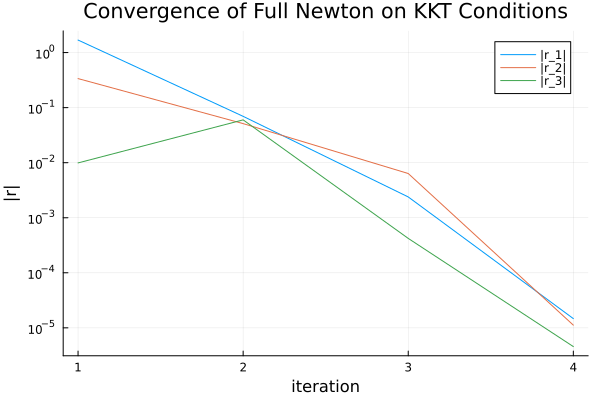

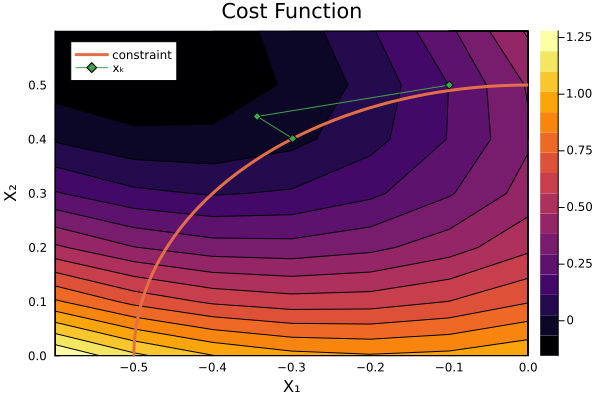

Test.DefaultTestSet("Full Newton", Any[], 2, false, false, true, 1.745281048204208e9, 1.745281051619032e9, false, "/home/burger/OCRL/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X13sZmlsZQ==.jl")

In [7]:
@testset "Full Newton" begin 
    
    
    z0 = [-.1, .5, 0] # initial guess
    merit_fx(_z) = norm(kkt_conditions(_z)) # simple merit function
    Z = newtons_method(z0, kkt_conditions, fn_kkt_jac, merit_fx; tol = 1e-4, 
    max_iters = 100, verbose = true)
    R = kkt_conditions.(Z)

    # make sure we converged on a solution to the KKT conditions 
    @test norm(kkt_conditions(Z[end])) < 1e-4
    @test length(R) < 6
    
    
    # ------------------------plotting stuff------------------------
    Rp = [[abs(R[i][ii]) + 1e-15 for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration
    
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Full Newton on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
    
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
    z1_hist = [z[1] for z in Z]
    z2_hist = [z[2] for z in Z]
    display(plot!(z1_hist, z2_hist, marker = :d, label = "xₖ"))
    # ------------------------plotting stuff------------------------
end

iter: 1    |r|: 1.7188450769812715   α: 1.0 
iter: 2    |r|: 0.8163267519728127   α: 1.0 
iter: 3    |r|: 0.1922177677011686   α: 1.0 
iter: 4    |r|: 0.04678866823071684   α: 1.0 
iter: 5    |r|: 0.0133893914077011   α: 1.0 
iter: 6    |r|: 0.003792680422273685   α: 1.0 
iter: 7    |r|: 0.0010784701647844727   α: 1.0 
iter: 8    |r|: 0.00030635243738783284   α: 1.0 
iter: 9    |r|: 8.7049117069183e-5   Test Summary: | Pass  Total  Time
Gauss-Newton  |    2      2  2.4s


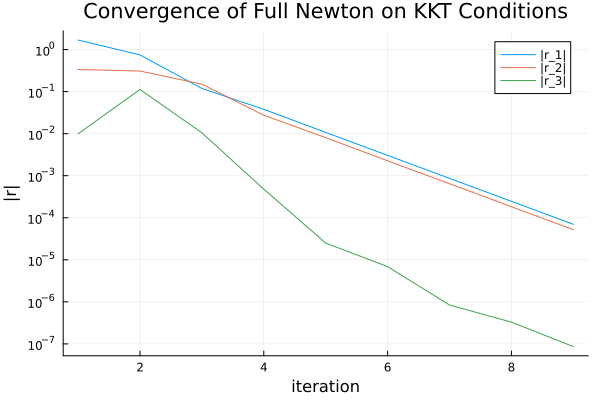

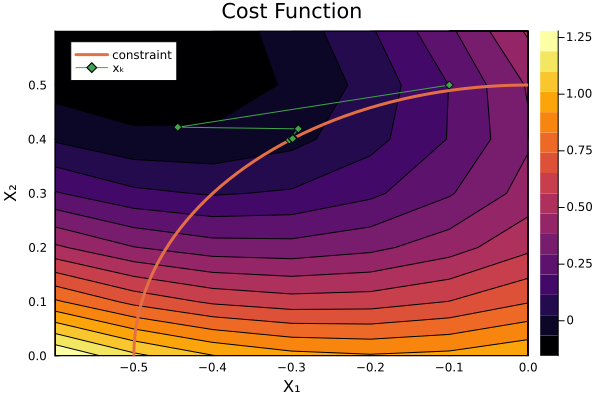

Test.DefaultTestSet("Gauss-Newton", Any[], 2, false, false, true, 1.745281051633013e9, 1.745281054072269e9, false, "/home/burger/OCRL/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl")

In [8]:
@testset "Gauss-Newton" begin 
    
    
    z0 = [-.1, .5, 0] # initial guess
    merit_fx(_z) = norm(kkt_conditions(_z)) # simple merit function
    
    # the only difference in this block vs the previous is `gn_kkt_jac` instead of `fn_kkt_jac`
    Z = newtons_method(z0, kkt_conditions, gn_kkt_jac, merit_fx; tol = 1e-4,
     max_iters = 100, verbose = true)
    R = kkt_conditions.(Z)

    # make sure we converged on a solution to the KKT conditions 
    @test norm(kkt_conditions(Z[end])) < 1e-4
    @test length(R) < 10
    
    
    # ------------------------plotting stuff------------------------
    Rp = [[abs(R[i][ii]) + 1e-15 for i = 1:length(R)] for ii = 1:length(R[1])] # this gets abs of each term at each iteration
    
    plot(Rp[1],yaxis=:log,ylabel = "|r|",xlabel = "iteration",
         yticks= [1.0*10.0^(-x) for x = float(15:-1:-2)],
         title = "Convergence of Full Newton on KKT Conditions",label = "|r_1|")
    plot!(Rp[2],label = "|r_2|")
    display(plot!(Rp[3],label = "|r_3|"))
    
    contour(-.6:.1:0,0:.1:.6, (x1,x2)-> cost([x1;x2]),title = "Cost Function",
            xlabel = "X₁", ylabel = "X₂",fill = true)
    xcirc = [.5*cos(θ) for θ in range(0, 2*pi, length = 200)]
    ycirc = [.5*sin(θ) for θ in range(0, 2*pi, length = 200)]
    plot!(xcirc,ycirc, lw = 3.0, xlim = (-.6, 0), ylim = (0, .6),label = "constraint")
    z1_hist = [z[1] for z in Z]
    z2_hist = [z[2] for z in Z]
    display(plot!(z1_hist, z2_hist, marker = :d, label = "xₖ"))
    # ------------------------plotting stuff------------------------
end

## Part B (10 pts): Balance a quadruped
Now we are going to solve for the control input $u \in \mathbb{R}^{12}$, and state $x \in \mathbb{R}^{30}$, such that the quadruped is balancing up on one leg at an equilibrium point. First, let's load in a dynamics model from `quadruped.jl`, where 

$ \dot{x} = f(x,u) =$ `dynamics(model, x, u)`



In [9]:
# include the functions from quadruped.jl
include(joinpath(@__DIR__, "quadruped.jl"))

# this loads in our continuous time dynamics function xdot = dynamics(model, x, u)

initialize_visualizer (generic function with 1 method)

let's load in a model and display the rough "guess" configuration that we are going for:

In [10]:
# --------these three are global variables------------
model = UnitreeA1() # contains all the model properties for the quadruped
mvis = initialize_visualizer(model) # visualizer 
const x_guess = initial_state(model) # our guess state for balancing
# ----------------------------------------------------

@show state_dim(model) # should be 30
@show control_dim(model) # should be 1

mech = model.mech

nq = num_positions(mech)
nv = num_velocities(mech)
println("num_positions = $nq")
println("num_velocities = $nv")
println("state_dim = ", 2*nq)

# 1) Print *all* joints
println("All joints (", length(collect(joints(mech))), "):")
for j in joints(mech)
    println(" • ", j.name, "  (fixed? ", isa(j.joint_type, Fixed), ")")
end


let all_bodies = collect(bodies(mech))
    println("Found $(length(all_bodies)) bodies:")
    for b in all_bodies
        println(" • ", b.name)
    end
end

set_configuration!(mvis, x_guess[1:state_dim(model)÷2])
render(mvis)

┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers /home/burger/.julia/packages/HTTP/4AUPl/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/burger/.julia/packages/MeshCat/9QrxD/src/visualizer.jl:43


state_dim(model) = 34
control_dim(model) = 12
num_positions = 17
num_velocities = 17
state_dim = 34
All joints (24):
 • RR_foot_joint_x  (fixed? false)
 • RL_foot_joint_x  (fixed? false)
 • RR_foot_joint_y  (fixed? false)
 • RL_foot_joint_y  (fixed? false)
 • RR_foot_joint_z  (fixed? false)
 • RL_foot_joint_z  (fixed? false)
 • RR_foot_fixed  (fixed? true)
 • RL_foot_fixed  (fixed? true)
 • RR_calf_joint  (fixed? false)
 • RL_calf_joint  (fixed? false)
 • RR_thigh_joint  (fixed? false)
 • RL_thigh_joint  (fixed? false)
 • RR_hip_joint  (fixed? false)
 • imu_joint  (fixed? true)
 • FR_hip_joint  (fixed? false)
 • FL_hip_joint  (fixed? false)
 • floating_base  (fixed? true)
 • FR_thigh_joint  (fixed? false)
 • FL_thigh_joint  (fixed? false)
 • FR_calf_joint  (fixed? false)
 • FL_calf_joint  (fixed? false)
 • FR_foot_fixed  (fixed? true)
 • FL_foot_fixed  (fixed? true)
 • RL_hip_joint  (fixed? false)
Found 24 bodies:
 • world
 • RR_dummy1
 • RL_dummy1
 • RR_dummy2
 • RL_dummy2
 • RR_foot


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RR_dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x52, 0x52, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RR_dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x52, 0x52, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RR_foot" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x79, 0x32, 0x2f, 0x52, 0x52, 0x5f, 0x66, 0x6f, 0x6f, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_foot_fixed" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x66, 0x69, 0x78, 0x65, 0x64], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_calf" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x74, 0x2f, 0x52, 0x52, 0x5f, 0x63, 0x61, 0x6c, 0x66], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_calf_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x6c, 0x66, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_thigh" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x2f, 0x52, 0x52, 0x5f, 0x74, 0x68, 0x69, 0x67, 0x68], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_thigh_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x69, 0x67, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_13" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_hip" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x67, 0x68, 0x2f, 0x52, 0x52, 0x5f, 0x68, 0x69, 0x70], Dict{String, Vec

Now, we are going to solve for the state and control that get us an equilibrium (balancing) on just one leg. We are going to do this by solving the following optimization problem:

$$ \begin{align} \min_{x,u} \quad & \frac{1}{2}(x - x_{guess})^T(x - x_{guess}) + \frac{1}{2}10^{-3} u^Tu \\ 
 \text{st} \quad & \dot{x} = f(x,u) = 0 
 \end{align}$$
 
 Where our primal variables are $x \in \mathbb{R}^{30}$ and $u \in \mathbb{R}^{12}$, that we can stack up in a new variable $y = [x^T, u^T]^T \in \mathbb{R}^{42}$. We have a constraint $\dot{x} = f(x,u) = 0$, which will ensure the resulting configuration is an equilibrium. This constraint is enforced with a dual variable $\lambda \in \mathbb{R}^{30}$. We are now ready to use Newton's method to solve this equality constrained optimization problem, where we will solve for a variable $z = [y^T, \lambda^T]^T \in \mathbb{R}^{72}$.
 
 In this next section, you should fill out `quadruped_kkt(z)` with the KKT conditions for this optimization problem, given the constraint is that `dynamics(model, x, u) = zeros(30)`. When forming the Jacobian of the KKT conditions, use the Gauss-Newton approximation for the hessian of the Lagrangian (see example above if you're having trouble with this).

In [11]:
# initial guess 
const x_guess = initial_state(model)

# indexing stuff 
const idx_x = 1:34 
const idx_u = 35:46
const idx_c = 47:80 

# I like stacking up all the primal variables in y, where y = [x;u]
# Newton's method will solve for z = [x;u;λ], or z = [y;λ]

function quadruped_cost(y::Vector)
    # cost function 
    # @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return cost 
    cost_qp = 0.5 * dot(x-x_guess,x-x_guess) + 0.5 * dot(u,u) * 1e-3
    #error("quadruped cost not implemented")
    return cost_qp
end

function quadruped_constraint(y::Vector)::Vector
    # constraint function 
    # @assert length(y) == 42
    x = y[idx_x]
    u = y[idx_u]
    
    # TODO: return constraint
    constraint_qp = dynamics(model, x, u)
    #error("quadruped constraint not implemented")

    return constraint_qp
end
function quadruped_kkt(z::Vector)::Vector
    # @assert length(z) == 72 
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    # TODO: return the KKT conditions 
    #error("quadruped kkt not implemented")
    stationarity_cdn = FD.gradient(quadruped_cost, y) + 
    FD.jacobian(quadruped_constraint, y)'*λ
    primal_feasibility = quadruped_constraint(y)
    return [stationarity_cdn; primal_feasibility]
end

function quadruped_kkt_jac(z::Vector)::Matrix
    @assert length(z) == 80
    x = z[idx_x]
    u = z[idx_u]
    λ = z[idx_c]
    
    y = [x;u]
    
    # TODO: return Gauss-Newton Jacobian with a regularizer (try 1e-3,1e-4,1e-5,1e-6)
    # and use whatever regularizer works for you
    #error("quadruped kkt jac not implemented")
    @show size(FD.hessian(quadruped_cost, y))
    @show size(FD.jacobian(quadruped_constraint, y))
    
    qp_kkt_jac = [FD.hessian(quadruped_cost, y) FD.jacobian(quadruped_constraint, y)';
                  FD.jacobian(quadruped_constraint, y) zeros(34,34)]
    qp_kkt_jac -= 1e-5 * I(length(z))
    return qp_kkt_jac
end

quadruped_kkt_jac (generic function with 1 method)

length(x_guess) = 34
length(z0) = 80
iter: 1    |r|: 66.16058631524271   size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
α: 0.125 
iter: 2    |r|: 61.256907124518385   size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
α: 0.25 
iter: 3    |r|: 59.74998007561563   size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
α: 0.25 
iter: 4    |r|: 54.24379723621463   size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
α: 0.5 
iter: 5    |r|: 49.0931636526322   size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
α: 1.0 
iter: 6    |r|: 25.717668950694144   size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
α: 1.0 
iter: 7    |r|: 1.2451642390367998   size(FD.hessian(quadruped_cost, y)) = (46, 46)
size

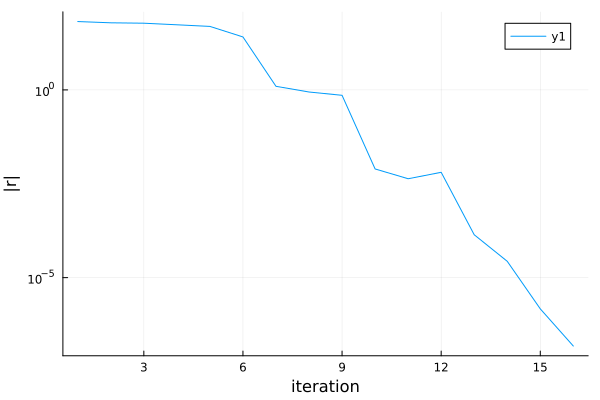

Test.DefaultTestSet("quadruped standing", Any[], 3, false, false, true, 1.745281065562849e9, 1.745281431176464e9, false, "/home/burger/OCRL/HW1_S25/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X24sZmlsZQ==.jl")

In [ ]:
function quadruped_merit(z)
    # merit function for the quadruped problem 
    # @assert length(z) == 72 
    r = quadruped_kkt(z)
    return norm(r[1:42]) + 1e4*norm(r[43:end])
end

@testset "quadruped standing" begin
    
    z0 = [x_guess; zeros(12); zeros(34)]
    @show length(x_guess) # should be 72
    @show length(z0) # should be 72
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit;
     tol = 1e-6, verbose = true, max_iters = 50)
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    R = norm.(quadruped_kkt.(Z))
    
    display(plot(1:length(R), R, yaxis=:log,xlabel = "iteration", ylabel = "|r|"))
    plot!(title = "Convergence of Quadruped KKT Conditions", label = "|r|") 
    
    @test R[end] < 1e-6
    @test length(Z) < 25
    
    x,u = Z[end][idx_x], Z[end][idx_u]
    
    @test norm(dynamics(model, x, u)) < 1e-6
    
end

In [ ]:
display(plot(1:length(R), R, yaxis=:log,xlabel = "iteration", ylabel = "|r|"))
plot!(title = "Convergence of Quadruped KKT Conditions", label = "|r|") 

UndefVarError: UndefVarError: `R` not defined

In [13]:

    
    # let's visualize the balancing position we found
    
    z0 = [x_guess; zeros(12); zeros(34)]
    Z = newtons_method(z0, quadruped_kkt, quadruped_kkt_jac, quadruped_merit;
     tol = 1e-6, verbose = false, max_iters = 50)
    # visualizer 
    mvis = initialize_visualizer(model)
    set_configuration!(mvis, Z[end][1:state_dim(model)÷2])
    render(mvis)
    
    
    
    


size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) = (34, 46)
size(FD.hessian(quadruped_cost, y)) = (46, 46)
size(FD.jacobian(quadruped_constraint, y)) =

┌ Info: Listening on: 127.0.0.1:8701, thread id: 1
└ @ HTTP.Servers /home/burger/.julia/packages/HTTP/4AUPl/src/Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat /home/burger/.julia/packages/MeshCat/9QrxD/src/visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RR_dummy1" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x52, 0x52, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x31], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RR_dummy2" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x52, 0x52, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RR_foot" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x79, 0x32, 0x2f, 0x52, 0x52, 0x5f, 0x66, 0x6f, 0x6f, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_foot_fixed" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x66, 0x69, 0x78, 0x65, 0x64], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_15" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x35], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x35], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_calf" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x74, 0x2f, 0x52, 0x52, 0x5f, 0x63, 0x61, 0x6c, 0x66], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_calf_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x63, 0x61, 0x6c, 0x66, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_thigh" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x2f, 0x52, 0x52, 0x5f, 0x74, 0x68, 0x69, 0x67, 0x68], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RR_thigh_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x69, 0x67, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_13" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RR_hip" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x69, 0x67, 0x68, 0x2f, 0x52, 0x52, 0x5f, 0x68, 0x69, 0x70], Dict{String, Vec

In [14]:
@show Z[end][1:state_dim(model)÷2]


(Z[end])[1:state_dim(model) ÷ 2] = [-0.00034439809533595776, -0.0003443411295774662, -0.31003837706183407, -0.31026351434074306, 0.00022619005887052431, 0.00022620868875846474, 0.23113053507838607, 0.23125895955618236, 0.1272482316068922, 0.1268946698434923, -0.0007997782745616991, -0.009836778663223645, 0.00979276787337494, 0.016964453132483102, 0.016964478734680957, 0.004758019542372259, 0.004758015930603157]


17-element Vector{Float64}:
 -0.00034439809533595776
 -0.0003443411295774662
 -0.31003837706183407
 -0.31026351434074306
  0.00022619005887052431
  0.00022620868875846474
  0.23113053507838607
  0.23125895955618236
  0.1272482316068922
  0.1268946698434923
 -0.0007997782745616991
 -0.009836778663223645
  0.00979276787337494
  0.016964453132483102
  0.016964478734680957
  0.004758019542372259
  0.004758015930603157

In [15]:
println("\n🔁 Revolute joints in the mechanism:")
for j in joints(model.mech)
    if typeof(j) <: Joint{Float64, Revolute{Float64}}
        println("  - ", j.name, " :: ", typeof(j))
    end
end


🔁 Revolute joints in the mechanism:
  - RR_foot_joint_x :: Joint{Float64, Revolute{Float64}}
  - RL_foot_joint_x :: Joint{Float64, Revolute{Float64}}
  - RR_foot_joint_y :: Joint{Float64, Revolute{Float64}}
  - RL_foot_joint_y :: Joint{Float64, Revolute{Float64}}
  - RR_foot_joint_z :: Joint{Float64, Revolute{Float64}}
  - RL_foot_joint_z :: Joint{Float64, Revolute{Float64}}
  - RR_calf_joint :: Joint{Float64, Revolute{Float64}}
  - RL_calf_joint :: Joint{Float64, Revolute{Float64}}
  - RR_thigh_joint :: Joint{Float64, Revolute{Float64}}
  - RL_thigh_joint :: Joint{Float64, Revolute{Float64}}
  - RR_hip_joint :: Joint{Float64, Revolute{Float64}}
  - FR_hip_joint :: Joint{Float64, Revolute{Float64}}
  - FL_hip_joint :: Joint{Float64, Revolute{Float64}}
  - FR_thigh_joint :: Joint{Float64, Revolute{Float64}}
  - FL_thigh_joint :: Joint{Float64, Revolute{Float64}}
  - FR_calf_joint :: Joint{Float64, Revolute{Float64}}
  - FL_calf_joint :: Joint{Float64, Revolute{Float64}}
  - RL_hip_join